<a href="https://colab.research.google.com/github/DhyeyShah794/poetry-analysis/blob/master/poetry_sentiment_analyzer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install scikit-learn sentence-transformers contractions nltk wordcloud langdetect

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.0/86.0 kB 1.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.5/981.5 kB 17.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 29.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 289.9/289.9 kB 15.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.8/110.8 kB 8.3 MB/s eta 0:00:00
  Created wheel for sentence-transformers: filename=sentence_transformers-2.2.2-py3-none-any.whl size=125923 sha256=271a4c088ac3f362969b14255df0b7fdd8f908be5269f7d1100661b4d77a0720
  Stored in directory: /root/.cache/pip/wheels/62/f2/10/1e606fd5f02395388f74e7462910fe851042f97238cbbd902f
  Created wheel for langdetect: filename=langdetect-1.0.9-py3-none-any.whl size=993225 sha256=c5070809288120c74cc532e9c99b33d19cf70f01bc5f2740b7919f83b157f07f
  Stored in directory: /root/.cache/pip/wheels/95/03/7d/59ea870c

In [2]:
!pip install git+https://github.com/cleanlab/cleanlab.git

  Cloning https://github.com/cleanlab/cleanlab.git to /tmp/pip-req-build-xz8m96h4
  Running command git clone --filter=blob:none --quiet https://github.com/cleanlab/cleanlab.git /tmp/pip-req-build-xz8m96h4
  Resolved https://github.com/cleanlab/cleanlab.git to commit bc10585352060aa48fa25f6f72dbf4961ea83fdf
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for cleanlab: filename=cleanlab-2.5.1-py3-none-any.whl size=307873 sha256=ee56468777ea5b5491c3e053dc62f0ff0993fe6652071bc32a5ad0a17f02fa21
  Stored in directory: /tmp/pip-ephem-wheel-cache-xlxlhayn/wheels/3d/53/8f/09fde0499e2135d2566a50fe7afd0398373244187206c7d441
Successfully built cleanlab
  Attempting uninstall: termcolor
    Found existing installation: termcolor 2.4.0
    Uninstalling termcolor-2.4.0:
      Successfully uninstalled termcolor-2.4.0


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import re
from langdetect import detect
import time
from ast import literal_eval
from sentence_transformers import SentenceTransformer, util
import unicodedata
import itertools
from collections import Counter
from cleanlab import Datalab
import contractions
import nltk
from nltk.corpus import wordnet, stopwords
from wordcloud import WordCloud, STOPWORDS
from nltk.stem import WordNetLemmatizer
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import accuracy_score, log_loss
from sklearn.model_selection import cross_val_predict
from sklearn.linear_model import LogisticRegression

In [2]:
data = pd.read_csv('https://raw.githubusercontent.com/DhyeyShah794/poetry-analysis/master/data.csv')

# Basic data exploration and cleaning

In [3]:
data.head()

,url,title,poem,categories
0,https://allpoetry.com/poem/17507453-s-q-u-e-l-...,s q u e l c h,s odden ground sounds\nq uenched earth belch...,['acrostic']
1,https://allpoetry.com/poem/17502390-A-haiku-ab...,A haiku about a hat,Hair under my rim\nAppalling mind below me\nTh...,"['haiku', 'acrostic', 'humor']"
2,https://allpoetry.com/poem/17499955-a-d-o-n-i-...,a d o n i s,a k.a tammuz\nancient hearttrob\ncanaanite y...,['acrostic']
3,https://allpoetry.com/poem/17499568-creating-b...,creating,i strive and slave and\nwill characters onto s...,"['haiku', 'acrostic']"
4,https://allpoetry.com/poem/17494731-w-o-a-h-by...,w o a h,wanda's orgasmic antique hatstand\nwolfgang'...,['acrostic']


In [4]:
# Rename poem to poem_text to avoid future conflicts with label names
data.rename(columns={'poem': 'poem_text'}, inplace=True)

In [5]:
data.describe()

,url,title,poem_text,categories
count,63731,63158,63400,63731
unique,63731,58548,63205,25106
top,https://allpoetry.com/poem/17507453-s-q-u-e-l-...,Graduation,I remember\nIt was the year\nThe grizzlies ran...,[]
freq,1,72,8,917


In [6]:
data.isnull().sum()

url             0
title         573
poem_text     331
categories      0
dtype: int64

In [7]:
# Remove those rows where the poem is empty or category values is an empty list
# Poems with no titles can also be used for analysis
data = data[data['poem_text'].notnull()]
data = data[~data['categories'].isin(['[]'])]

# Tokenization and lemmatization

In [8]:
def tokenize(column):
  cleaned = ' '.join([re.sub(r'[^\w\s]', '', contractions.fix(word).lower()) for word in column.split()])
  tokens = nltk.WhitespaceTokenizer().tokenize(cleaned)
  return [word for word in tokens if re.match(r'^[a-zA-Z]+$', word)]

In [9]:
data['tokenized'] = data['poem_text'].apply(lambda x: tokenize(x))

In [10]:
def pos_tagger(nltk_tag):
    if nltk_tag.startswith('J'):
        return wordnet.ADJ
    elif nltk_tag.startswith('V'):
        return wordnet.VERB
    elif nltk_tag.startswith('N'):
        return wordnet.NOUN
    elif nltk_tag.startswith('R'):
        return wordnet.ADV
    else:
        return None

In [11]:
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
lemmatizer = WordNetLemmatizer()

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


In [12]:
def lemmatize_word(word, tag):
  if tag is None:
    return word
  else:
    return lemmatizer.lemmatize(word, tag)

In [13]:
def lemmatize_text(tokenized):
    pos_tagged = nltk.pos_tag(tokenized)
    lemmatized_tokens = [lemmatize_word(word, pos_tagger(tag)) for word, tag in pos_tagged]
    return " ".join(lemmatized_tokens)

In [14]:
data['lemmatized'] = data['tokenized'].apply(lambda x: lemmatize_text(x))

In [15]:
# If the lemmatized value is an empty string, it means there was no text in the Roman script
# We can safely discard such entries
data = data[data['lemmatized'].str.strip() != '']

In [16]:
data[data['lemmatized']=='']

,url,title,poem_text,categories,tokenized,lemmatized


In [17]:
# Languages like German, French, Spanish can still be transliterated using the Roman alphabet
# So detect the language of each poem and then filter out everything other than English
data['language'] = data['poem_text'].apply(lambda x: detect(x))

In [18]:
print(data['language'].value_counts())

en    62196
fr       47
af       31
nl       26
id       18
tl       14
da       14
de       12
es       12
no       10
it        9
cy        9
ro        8
ca        6
pt        6
et        6
so        6
sv        5
sw        5
hu        4
hi        4
ru        3
pl        2
tr        2
hr        2
fi        2
sk        2
sl        2
lt        2
vi        1
ta        1
sq        1
uk        1
bg        1
lv        1
Name: language, dtype: int64


In [19]:
# Drop every row where the language is not English, since it accounts for less than 5% of the dataset
data = data[data['language'] == 'en']

In [20]:
# Irrelevant data (random text entries and stuff)
indices_to_remove = data[data['url'].str.contains('Betweenkittensandriots')].index
data = data.drop(indices_to_remove)

In [21]:
# Convert category values from str to list
data['categories'] = data['categories'].apply(literal_eval)

In [22]:
def get_cat_freq():  # Returns a dict containing the frequency of each category
  cat_freq = {}
  for value in itertools.chain.from_iterable(data['categories']):
    cat_freq[value] = cat_freq.get(value, 0) + 1
  return cat_freq

In [23]:
cat_freq = get_cat_freq()
unique_cats = sorted((set(cat_freq.keys())))
print(len(unique_cats))
print(unique_cats)

232
['acrostic', 'africa', 'alone', 'america', 'angel', 'anger', 'animal', 'anniversary', 'april', 'august', 'autumn', 'baby', 'ballad', 'beach', 'beautiful', 'beauty', 'believe', 'bipolar', 'birth', 'brother', 'butterfly', 'candy', 'car', 'cat', 'change', 'chicago', 'child', 'childhood', 'children', 'chocolate', 'christian', 'christmas', 'cinderella', 'city', 'concrete', 'couplet', 'courage', 'crazy', 'culture', 'dance', 'dark', 'dark-humor', 'daughter', 'death', 'depression', 'despair', 'destiny', 'discrimination', 'dog', 'dream', 'education', 'elegy', 'epic', 'evil', 'fairy', 'faith', 'family', 'farewell', 'fate', 'father', 'fear', 'fire', 'fish', 'fishing', 'flower', 'fog', 'food', 'football', 'freedom', 'friend', 'frog', 'fun', 'funeral', 'funny', 'future', 'girl', 'god', 'golf', 'graduate', 'graduation', 'greed', 'green', 'grief', 'guitar', 'haiku', 'hair', 'happiness', 'happy', 'hate', 'heart', 'heaven', 'hero', 'history', 'holocaust', 'home', 'homework', 'honesty', 'hope', 'hor

In [24]:
n = 25
total_count = sum(cat_freq.values())

counter = Counter(cat_freq)
most_freq, least_freq = counter.most_common(n), counter.most_common()[:-n-1:-1]

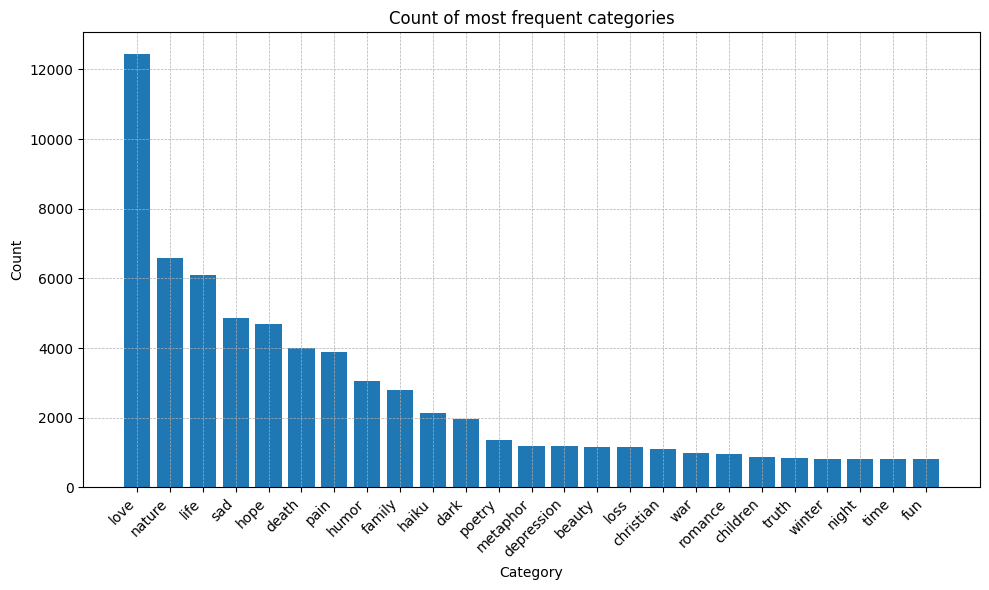

In [25]:
cats, counts = zip(*most_freq)
plt.figure(figsize=(10, 6))
plt.bar(cats, counts)
plt.xlabel('Category')
plt.ylabel('Count')
plt.title(f'Count of most frequent categories')
plt.xticks(rotation=45, ha='right')
plt.grid(True, linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()

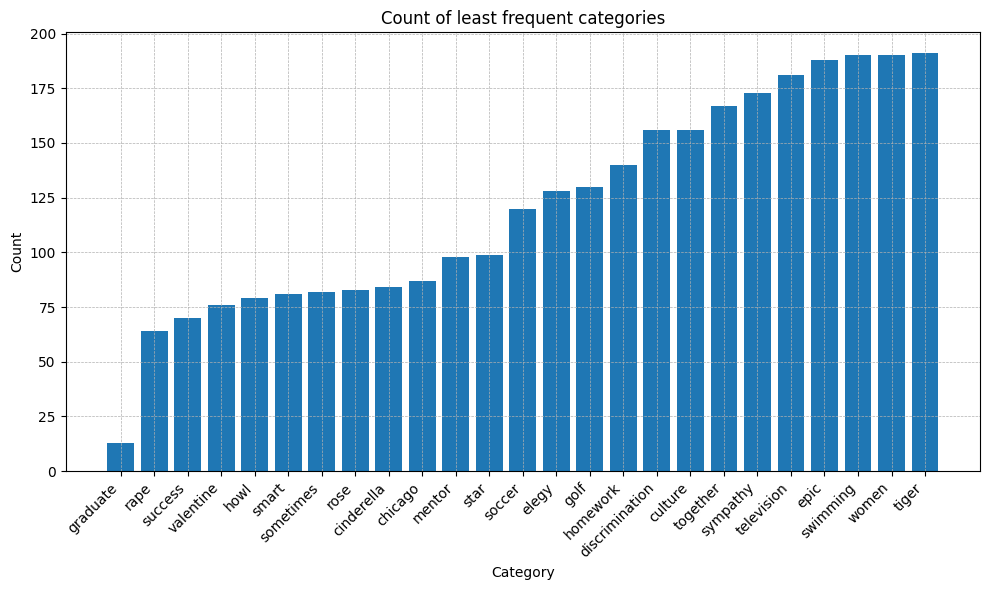

In [26]:
cats, counts = zip(*least_freq)
plt.figure(figsize=(10, 6))
plt.bar(cats, counts)
plt.xlabel('Category')
plt.ylabel('Count')
plt.title(f'Count of least frequent categories')
plt.xticks(rotation=45, ha='right')
plt.grid(True, linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()

Text(0.5, 1.0, 'Histogram of Poem Lengths')

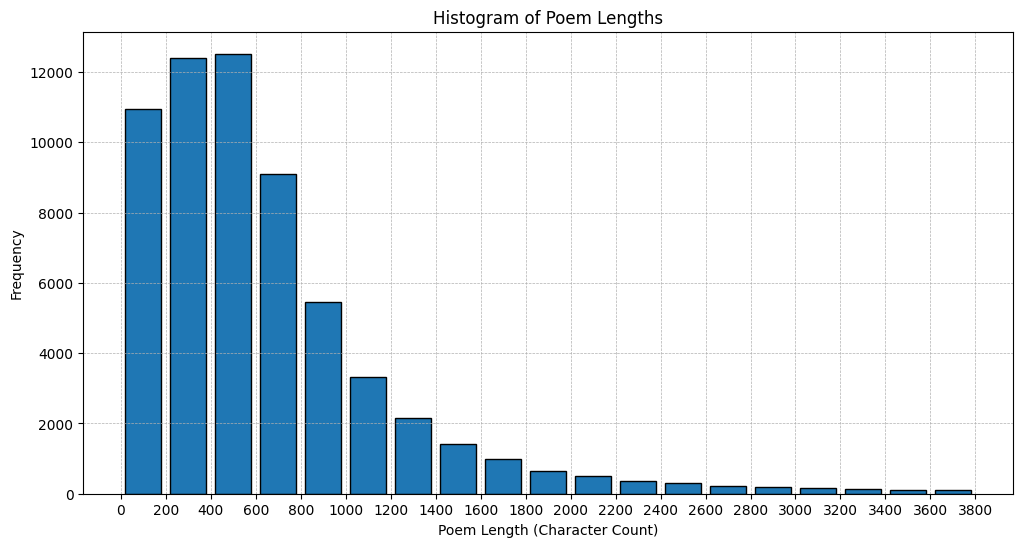

In [27]:
data['poem_length'] = data['poem_text'].apply(len)
intervals = [i * 200 for i in range(20)]

plt.figure(figsize=(12, 6))
plt.hist(data['poem_length'], bins=intervals, edgecolor='black', rwidth=0.8)
plt.grid(True, linestyle='--', linewidth=0.5)
plt.xticks(intervals)

plt.xlabel('Poem Length (Character Count)')
plt.ylabel('Frequency')
plt.title('Histogram of Poem Lengths')

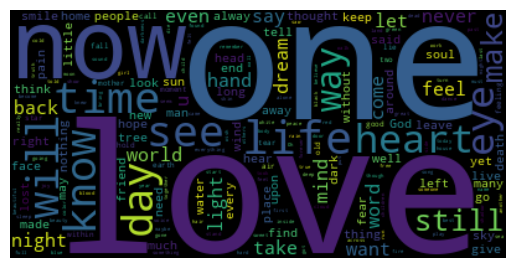

In [28]:
text = " ".join(poem for poem in data['poem_text'])
wordcloud = WordCloud().generate(text)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.savefig('wordcloud.png')
plt.show()

In [29]:
def word_count(text):
  words = re.findall(r'\w+', text)
  return len(words)

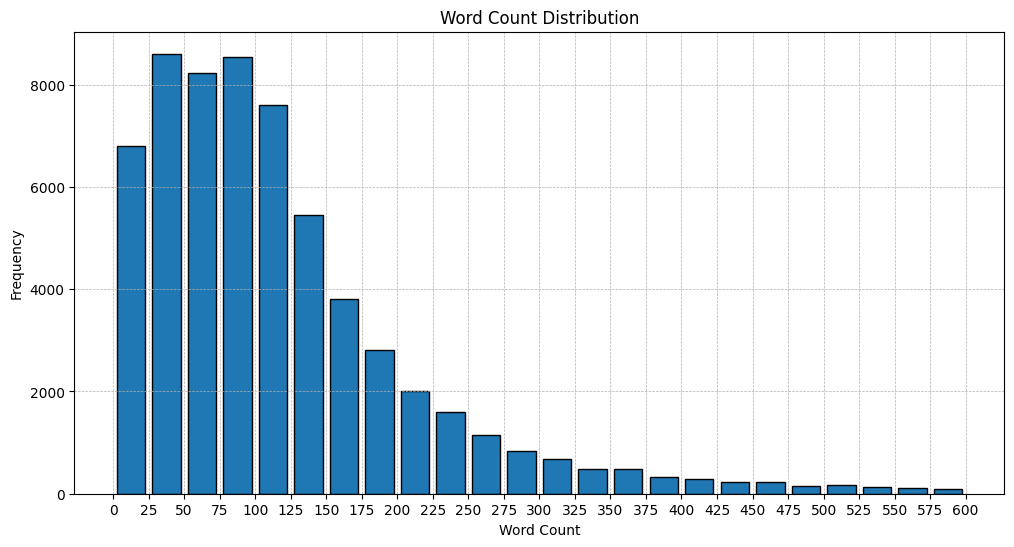

In [30]:
data['word_count'] = data['poem_text'].apply(word_count)
intervals = [i * 25 for i in range (25)]

plt.figure(figsize=(12, 6))
plt.hist(data['word_count'], bins=intervals, edgecolor='black', rwidth=0.8)
plt.grid(True, linestyle='--', linewidth=0.5)
plt.xlabel('Word Count')
plt.ylabel('Frequency')
plt.title('Word Count Distribution')
plt.xticks(intervals)

plt.show()

# Combining semantically similar categories

In [31]:
# Optional code (to get similar categories using their cosine scores)

# model = SentenceTransformer('all-MiniLM-L6-v2')

# pairs = list(itertools.combinations(unique_cats, 2))
# cosine_scores = []

# for pair in pairs:
#   cat1 = pair[0]
#   cat2 = pair[1]

#   embeddings1 = model.encode(cat1)
#   embeddings2 = model.encode(cat2)

#   cosine_score = util.cos_sim(embeddings1, embeddings2)
#   cosine_scores.append(cosine_score.item())

# threshold = 0.7
# new = [(i, cosine_scores[i]) for i in range(len(cosine_scores)) if cosine_scores[i] >= threshold]
# similar_pairs = [pairs[value[0]] for value in new]

In [32]:
# The first item in each tuple to be replaced with the second item
cats_to_update = (
    ('children', 'child'),
    ('beautiful', 'beauty'),
    ('sunshine', 'sun'),
    ('sunset', 'sun'),
    ('mom', 'mother'),
    ('women', 'woman'),
    ('fishing', 'fish'),
    ('soccer', 'football'),
    ('graduate', 'graduation'),
    ('wedding', 'marriage'),
    ('ocean', 'sea'),
    ('poetry', 'poem'),
    ('romantic', 'romance'),
    )

In [33]:
def update_categories(old, new):
  # temp_obj = data['categories'].explode().replace(old, new)
  # temp_obj = temp_obj.to_frame().groupby(level=0).agg(list)
  # data['categories'] = temp_obj
  all_lists = data['categories'].to_list()
  for cat_list in all_lists:
    if old in cat_list and new not in cat_list:
      cat_list[cat_list.index(old)] = new
    elif (old, new) in cat_list:
      cat_list.remove(old)

In [34]:
for values in cats_to_update:
  update_categories(*values)

In [35]:
if len(unique_cats) - len(get_cat_freq()) == len(cats_to_update):
  print("Categories updated successfully")

In [36]:
# Reassign updated values
cat_freq = get_cat_freq()
unique_cats = sorted((set(cat_freq.keys())))

# Vectorization

In [37]:
data.head()

,url,title,poem_text,categories,tokenized,lemmatized,language,poem_length,word_count
0,https://allpoetry.com/poem/17507453-s-q-u-e-l-...,s q u e l c h,s odden ground sounds\nq uenched earth belch...,[acrostic],"[s, odden, ground, sounds, q, uenched, earth, ...",s odden grind sound q uenched earth belch you ...,en,173,34
1,https://allpoetry.com/poem/17502390-A-haiku-ab...,A haiku about a hat,Hair under my rim\nAppalling mind below me\nTh...,"[haiku, acrostic, humor]","[hair, under, my, rim, appalling, mind, below,...",hair under my rim appalling mind below me the ...,en,63,13
2,https://allpoetry.com/poem/17499955-a-d-o-n-i-...,a d o n i s,a k.a tammuz\nancient hearttrob\ncanaanite y...,[acrostic],"[a, ka, tammuz, ancient, hearttrob, canaanite,...",a ka tammuz ancient hearttrob canaanite yoof t...,en,510,88
3,https://allpoetry.com/poem/17499568-creating-b...,creating,i strive and slave and\nwill characters onto s...,"[haiku, acrostic]","[i, strive, and, slave, and, will, characters,...",i strive and slave and will character onto scr...,en,230,42
4,https://allpoetry.com/poem/17494731-w-o-a-h-by...,w o a h,wanda's orgasmic antique hatstand\nwolfgang'...,[acrostic],"[wandas, orgasmic, antique, hatstand, wolfgang...",wandas orgasmic antique hatstand wolfgangs orr...,en,147,20


In [38]:
# To avoid imbalance between classes, we define a minimum threshold of n = 1% of the total data items
# If a category has fewer than n samples, we do not consider it for training

n = 0.01 * data.shape[0]  # n ~ 619
filtered_cat_freq = {k: v for k, v in cat_freq.items() if v >= n}
discarded = list(set(unique_cats) - (set(filtered_cat_freq.keys())))

In [39]:
print(f"Filtered {len(filtered_cat_freq)} categories")
print(f"Discarded {len(discarded)} categories")

if set(filtered_cat_freq).intersection(set(discarded)) == set():
  print("No overlaps found")

Filtered 52 categories
Discarded 180 categories
No overlaps found


In [40]:
def remove_category(cat):
  all_lists = data['categories'].to_list()
  for cat_list in all_lists:
    if cat in cat_list:
      cat_list.remove(cat)

In [41]:
# MultiLabelBinarizer creates new columns from the dataset directly
# Need to remove all instances of the discarded categories from 'categories'

start = time.time()
for cat in discarded:
  remove_category(cat)
print(time.time() - start)

1.4513356685638428


In [42]:
cat_freq = get_cat_freq()
unique_cats = sorted((set(cat_freq.keys())))

In [43]:
print(f"Pre-vectorization column count: {len(data.columns)}")

Pre-vectorization column count: 9


In [44]:
data.head()

,url,title,poem_text,categories,tokenized,lemmatized,language,poem_length,word_count
0,https://allpoetry.com/poem/17507453-s-q-u-e-l-...,s q u e l c h,s odden ground sounds\nq uenched earth belch...,[],"[s, odden, ground, sounds, q, uenched, earth, ...",s odden grind sound q uenched earth belch you ...,en,173,34
1,https://allpoetry.com/poem/17502390-A-haiku-ab...,A haiku about a hat,Hair under my rim\nAppalling mind below me\nTh...,"[haiku, humor]","[hair, under, my, rim, appalling, mind, below,...",hair under my rim appalling mind below me the ...,en,63,13
2,https://allpoetry.com/poem/17499955-a-d-o-n-i-...,a d o n i s,a k.a tammuz\nancient hearttrob\ncanaanite y...,[],"[a, ka, tammuz, ancient, hearttrob, canaanite,...",a ka tammuz ancient hearttrob canaanite yoof t...,en,510,88
3,https://allpoetry.com/poem/17499568-creating-b...,creating,i strive and slave and\nwill characters onto s...,[haiku],"[i, strive, and, slave, and, will, characters,...",i strive and slave and will character onto scr...,en,230,42
4,https://allpoetry.com/poem/17494731-w-o-a-h-by...,w o a h,wanda's orgasmic antique hatstand\nwolfgang'...,[],"[wandas, orgasmic, antique, hatstand, wolfgang...",wandas orgasmic antique hatstand wolfgangs orr...,en,147,20


In [45]:
mlb = MultiLabelBinarizer()

In [46]:
data = data.join(pd.DataFrame(mlb.fit_transform(data['categories']), index=data.index, columns=mlb.classes_))

In [47]:
print(f"Post-vectorization column count: {len(data.columns)}")

Post-vectorization column count: 61


In [48]:
# Check whether any discarded category is present in the column names list
if set(list(mlb.classes_)).intersection(set(discarded)) == set():
  print("None of the discarded categories were vectorized")

None of the discarded categories were vectorized


In [49]:
data.head()

,url,title,poem_text,categories,tokenized,lemmatized,language,poem_length,word_count,autumn,...,sad,sea,spring,summer,sun,time,truth,war,winter,world
0,https://allpoetry.com/poem/17507453-s-q-u-e-l-...,s q u e l c h,s odden ground sounds\nq uenched earth belch...,[],"[s, odden, ground, sounds, q, uenched, earth, ...",s odden grind sound q uenched earth belch you ...,en,173,34,0,...,0,0,0,0,0,0,0,0,0,0
1,https://allpoetry.com/poem/17502390-A-haiku-ab...,A haiku about a hat,Hair under my rim\nAppalling mind below me\nTh...,"[haiku, humor]","[hair, under, my, rim, appalling, mind, below,...",hair under my rim appalling mind below me the ...,en,63,13,0,...,0,0,0,0,0,0,0,0,0,0
2,https://allpoetry.com/poem/17499955-a-d-o-n-i-...,a d o n i s,a k.a tammuz\nancient hearttrob\ncanaanite y...,[],"[a, ka, tammuz, ancient, hearttrob, canaanite,...",a ka tammuz ancient hearttrob canaanite yoof t...,en,510,88,0,...,0,0,0,0,0,0,0,0,0,0
3,https://allpoetry.com/poem/17499568-creating-b...,creating,i strive and slave and\nwill characters onto s...,[haiku],"[i, strive, and, slave, and, will, characters,...",i strive and slave and will character onto scr...,en,230,42,0,...,0,0,0,0,0,0,0,0,0,0
4,https://allpoetry.com/poem/17494731-w-o-a-h-by...,w o a h,wanda's orgasmic antique hatstand\nwolfgang'...,[],"[wandas, orgasmic, antique, hatstand, wolfgang...",wandas orgasmic antique hatstand wolfgangs orr...,en,147,20,0,...,0,0,0,0,0,0,0,0,0,0


# Experimenting with cleanlab

In [ ]:
# new = data.copy()
# new.drop(new.index[-60_000:], inplace=True)
# new.shape

In [ ]:
raw_texts, labels, urls = data["poem"].values, data["categories"].values, data["url"].values
num_classes = len(set(labels))

print(f"This dataset has {num_classes} classes.")
print(f"Classes: {set(labels)}")

This dataset has 25036 classes.
Classes: {'romance,love,butterfly', 'horse,animal,humor,nature,love', 'marriage,life,suicide,death', 'beauty,happiness,family', 'discrimination,world,racism,prejudice', 'pink,dance', 'fear,song,hope', 'lgbtq,thanks,love', 'hope,faith,war', 'people,world,water', 'school,teacher,summer,humor', 'love,valentine,future', 'sunset,nature,autumn', 'despair,world,crazy', 'loss,hope,grief,death,family,son', 'moon,music,night', 'love,humor,hope,peace,family', 'sad,love,friend,lost', 'hair,night', 'sad,butterfly', 'beauty,fire,love,hope', 'pain,love,poem,time', 'racism,daughter,family', 'swimming,alone', 'poetry,anniversary', 'love,acrostic,joy,life', 'pain,loss,sad,sister,death,family', 'travel,respect', 'love,hate,grief,family,sorrow', 'passion,inspiration,music,night,chocolate', 'innocence,war', 'song,humor,children,music,candy', 'greed,death,grief', 'honesty,pain,journey,hope', 'love,metaphor,sleep', 'night,purple,nature', 'dark,night,snake,life,pride', 'love,ep

In [ ]:
transformer = SentenceTransformer('google/electra-small-discriminator')
text_embeddings = transformer.encode(raw_texts)

In [ ]:
model = LogisticRegression(max_iter=400)

pred_probs = cross_val_predict(model, text_embeddings, labels, method="predict_proba")

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


In [ ]:
data_dict = {"texts": raw_texts, "labels": labels}

In [ ]:
lab = Datalab(data_dict, label_name="labels")
lab.find_issues(pred_probs=pred_probs, features=text_embeddings)

In [ ]:
lab.report()

In [ ]:
for i in [1619, 1668, 2333, 2337, 2255, 2398]:
  print(f"URL: {urls[i]}")
  print(f"Category: {labels[i]}")
  print(f"Poem: {raw_texts[i][:50]}")

URL: https://allpoetry.com/poem/16395872-An-Angel-Can-Fall-From-Above-by-Katrine-K%C3%A6rsvang
Category: christian,angel,pain,love
Poem: An angel can find you
in a sadden dwell
A bond she
URL: https://allpoetry.com/poem/16161285-An-angel-can-fall-from-above-by-AngelicKatrine
Category: god,angel,sad,love
Poem: An angel can find you
in a sadden dwell
A bond she
URL: https://allpoetry.com/poem/16831008-The-stones-are-my-mind-by-Eyewind--by-Eyewind
Category: metaphor,animal
Poem: Rocks are like the waves of the sea
They are wave 
URL: https://allpoetry.com/poem/16824865-The-stones-are-my-mind-by-Eyewind-by-Eyewind
Category: metaphor,fire,animal
Poem: Rocks are like the waves of the sea
They are wave 
URL: https://allpoetry.com/poem/14244434-A-Native-of-Florida-s-Reefs----Fishing--by-Dr.Ram-Mehta
Category: animal
Poem: I am the native of the Florida Keys and Bahamas
Pe
URL: https://allpoetry.com/poem/16667594-A-Native-of-Florida-s-Reefs----Animal--by-Dr.Ram-Mehta
Category: animal
Poem: I am